In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import optuna
import joblib
from phik import phik_matrix

/home/neuralist/DS&ML/kaggle/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### EDA

In [2]:
data_train = pd.read_csv('data/train.csv')
data_train

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,Adidas,Leather,Small,9.0,No,No,Tote,Blue,12.730812,129.99749
299996,299996,Jansport,Leather,Large,6.0,No,Yes,Tote,Blue,26.633182,19.85819
299997,299997,Puma,Canvas,Large,9.0,Yes,Yes,Backpack,Pink,11.898250,111.41364
299998,299998,Adidas,Nylon,Small,1.0,No,Yes,Tote,Pink,6.175738,115.89080


Поскольку таргет в тестовой части нам неизвестен, выделим часть трейновой части для валидации созданных моделей

In [3]:
# X = data_train.drop('Price', axis=1)
X = data_train
y = data_train['Price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=8)

Пропуски в данных

In [4]:
# Сразу удалим признак id как не несущий полезной информации
X_train = X_train.drop('id', axis=1)
X_val = X_val.drop('id', axis=1)

X_train.isna().sum()

Brand                   7294
Material                6268
Size                    4914
Compartments               0
Laptop Compartment      5561
Waterproof              5215
Style                   5913
Color                   7514
Weight Capacity (kg)     111
Price                      0
dtype: int64

In [5]:
X_val.isna().sum()

Brand                   2411
Material                2079
Size                    1681
Compartments               0
Laptop Compartment      1883
Waterproof              1835
Style                   2057
Color                   2436
Weight Capacity (kg)      27
Price                      0
dtype: int64

In [6]:
X_train.describe(include='object')

,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color
count,217706,218732,220086,219439,219785,219087,217486
unique,5,4,3,2,2,3,6
top,Adidas,Polyester,Medium,Yes,Yes,Messenger,Pink
freq,45200,59720,76552,111344,111100,75040,38813


In [7]:
X_train.describe()

,Compartments,Weight Capacity (kg),Price
count,225000.000000,224889.000000,225000.000000
mean,5.442538,18.040247,81.402921
std,2.891775,6.972472,39.054052
min,1.000000,5.000000,15.000000
25%,3.000000,12.099788,47.353490
50%,5.000000,18.077288,80.956705
75%,8.000000,24.038977,115.023780
max,10.000000,30.000000,150.000000


In [8]:
# Заменим пропущенные данные в категориальных признаках на `no info`
categorical_cols = X_train.select_dtypes('object').columns.to_list()
X_train[categorical_cols] = X_train[categorical_cols].fillna('no info')
X_val[categorical_cols] = X_val[categorical_cols].fillna('no info')

# Заменим пропущенные данные в числовых признаках на медиану
numerical_cols = X_train.select_dtypes([int, float]).columns.to_list()
median = X_train['Weight Capacity (kg)'].median()

X_train['Weight Capacity (kg)'] = X_train['Weight Capacity (kg)'].fillna(median)
X_val['Weight Capacity (kg)'] = X_val['Weight Capacity (kg)'].fillna(median)

Выбросы

<Axes: xlabel='Weight Capacity (kg)', ylabel='Count'>

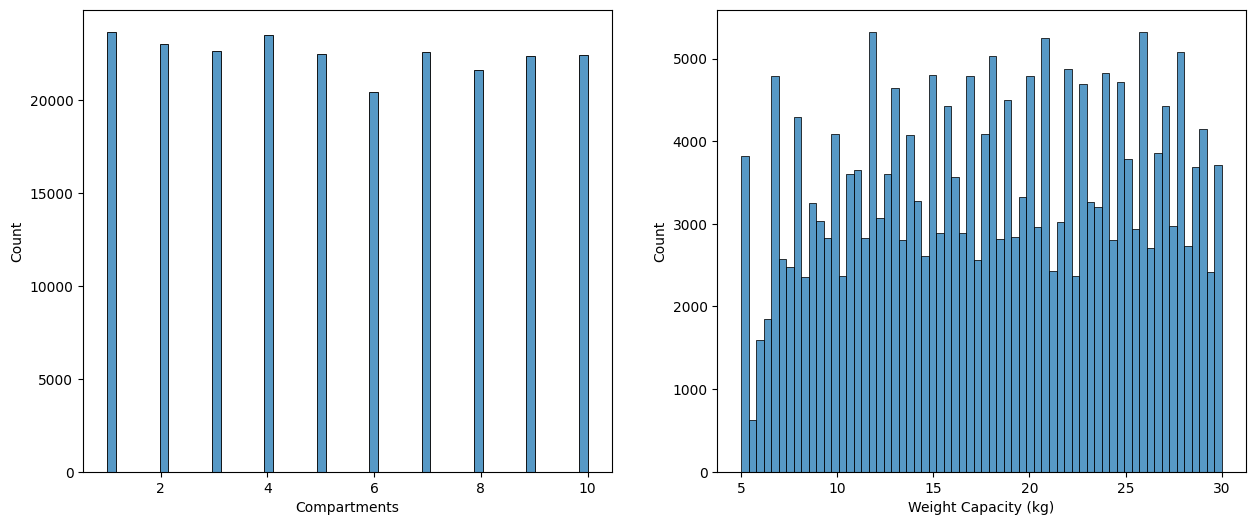

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 6))
sns.histplot(data=X_train, x='Compartments',ax=axes[0])
sns.histplot(data=X_train, x='Weight Capacity (kg)',ax=axes[1])

Корреляции

<Axes: >

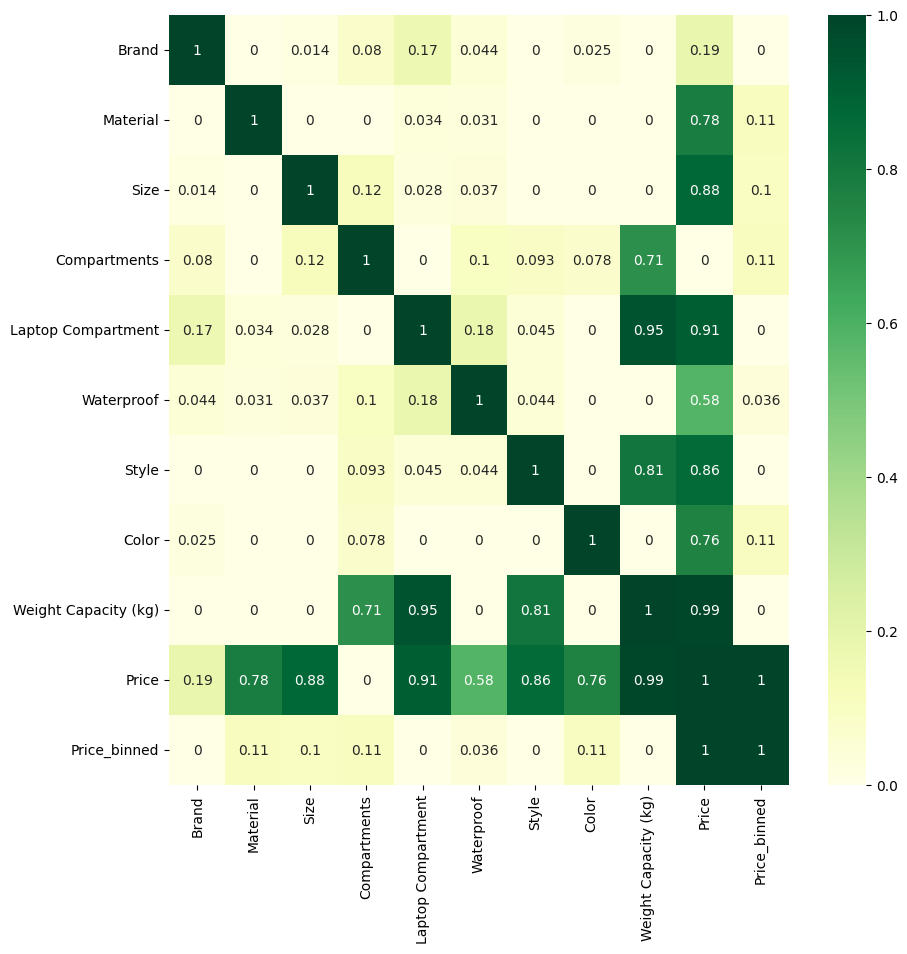

In [79]:
X_sample = X_train.copy().sample(1000)

# Разбиение непрерывной переменной на биновые интервалы
X_sample['Price_binned'] = pd.qcut(X_sample['Price'], q=10, labels=False)

# Создание матрицы корреляции phi_k
correlation_matrix = phik_matrix(X_sample, interval_cols=['Price_binned'])

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGn')

<Axes: >

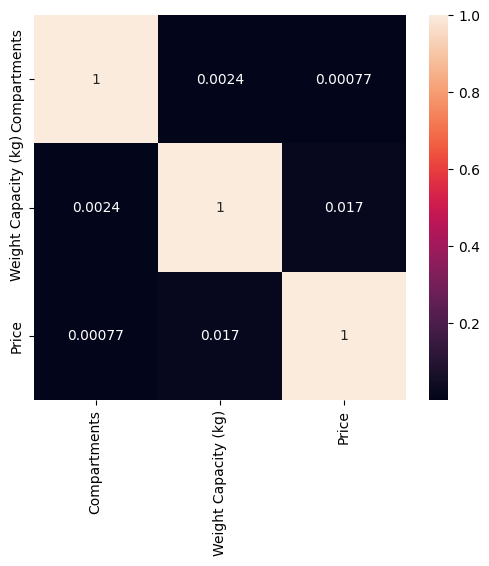

In [80]:
# numerical_cols = X_train.select_dtypes('number').columns.tolist()
corr_mat = X_train[numerical_cols].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_mat, annot=True)

### Baseline

In [10]:
X_train = X_train.drop('Price', axis=1)
X_val = X_val.drop('Price', axis=1)
numerical_cols.remove('Price')

In [88]:
# Преобразование числовых столбцов
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())  # Масштабирование непрерывных числовых признаков
])

categorical_transformer = Pipeline(steps=[
    ('encoder', TargetEncoder())  # Масштабирование категориальных признаков
])

# Объединяем преобразования с помощью ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

param_grid = {'regressor__alpha': np.logspace(-1, 3, 10)}

# Настройка GridSearchCV
gs_lr = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

# Обучаем модели с различными гиперпараметрами
gs_lr.fit(X_train, y_train)


y_pred = gs_lr.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'RMSE: {rmse:.3f}')
print(f'Target mean value: {y_val.mean():.3f}')
print(gs_lr.best_params_)

RMSE: 38.974
Target mean value: 81.436
{'regressor__alpha': 1000.0}


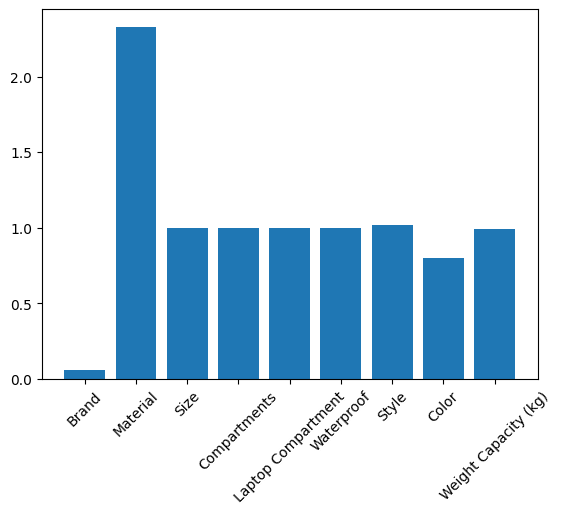

In [99]:
weights = gs_lr.best_estimator_.named_steps['regressor'].coef_
features_names = X_train.columns.to_list()
plt.figure()
plt.bar(x=features_names, height=weights)
plt.xticks(rotation=45)
plt.show()

### Catboost

In [100]:
cb = CatBoostRegressor(cat_features=categorical_cols, logging_level='Silent')

cb.fit(X_train, y_train)
y_pred = cb.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'RMSE: {rmse:.3f}')
print(f'Target mean value: {y_val.mean():.3f}')

RMSE: 38.967
Target mean value: 81.436


Для дальнейших экспериментов, уменьшим размер X_train и X_val до 10000

In [81]:
X_train = X_train.iloc[:10000, :]
y_train = y_train.iloc[:10000]
X_val = X_val.iloc[:10000, :]
y_val = y_val.iloc[:10000]

### CatBoost + Optuna

In [ ]:
def objective(trial):
    # Определяем гиперпараметры для оптимизации
    iterations = trial.suggest_int('iterations', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1, log=True)
    depth = trial.suggest_int('depth', 2, 10)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.01, 1, log=True)


    # Создаем модель
    model = CatBoostRegressor(cat_features=categorical_cols,
                              iterations=iterations,
                              depth=depth,
                              learning_rate=learning_rate,
                              l2_leaf_reg=l2_leaf_reg,
                              logging_level='Silent',
                              random_state=42)

    score = cross_val_score(model,
                            X_train, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

    return -score

study_cb = optuna.create_study()
study_cb.optimize(objective, n_trials=30)
best_params_cb = study_cb.best_params

In [13]:
# Создаем модель с лучшими гиперпараметрами
best_cb_model = CatBoostRegressor(cat_features=categorical_cols,
                                  logging_level='Silent',
                                  **best_params_cb)

best_cb_model.fit(X_train, y_train)
y_pred = best_cb_model.predict(X_val)
rmse_optuna = root_mean_squared_error(y_val, y_pred)
print(f'CatBoost + optuna RMSE: {rmse_optuna:.5f}')

CatBoost + optuna RMSE: 38.96486


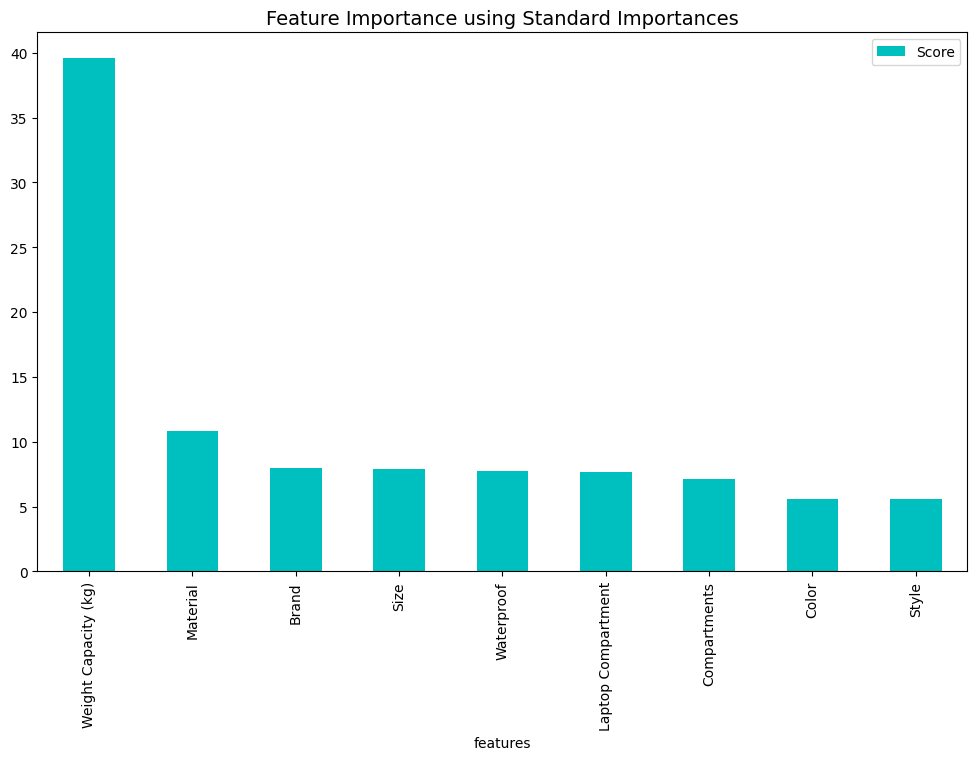

In [14]:
fi_1 = best_cb_model.feature_importances_

feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, fi_1)),
                                    columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Feature Importance using {}".format('Standard Importances'), fontsize = 14)
ax.set_xlabel("features")
plt.show()

### RandomForest

In [16]:
# Кодируем категориальные признаки при помощи OneHotEncoder
ohe_enc = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False).set_output(transform='pandas')

X_train_encoded = ohe_enc.fit_transform(X_train[categorical_cols])
X_val_encoded = ohe_enc.transform(X_val[categorical_cols])

In [18]:
def objective_rf(trial):
    # Определите гиперпараметры для подбора
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    }

    model = RandomForestRegressor(criterion='squared_error', **params)
    score = cross_val_score(model,
                            X_train_encoded, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

    return -score

# Запуск оптимизации
study_rf = optuna.create_study()
study_rf.optimize(objective_rf, n_trials=30)
best_params_rf = study_rf.best_params

[I 2025-02-28 12:49:03,295] A new study created in memory with name: no-name-47fb193a-9d4c-441d-b85b-4b807dc43b7f
[I 2025-02-28 12:49:09,185] Trial 0 finished with value: 39.04227876685385 and parameters: {'n_estimators': 112, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 0 with value: 39.04227876685385.
[I 2025-02-28 12:49:15,210] Trial 1 finished with value: 39.040645751036884 and parameters: {'n_estimators': 138, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 1 with value: 39.040645751036884.
[I 2025-02-28 12:49:32,561] Trial 2 finished with value: 39.0535034108434 and parameters: {'n_estimators': 105, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 1 with value: 39.040645751036884.
[I 2025-02-28 12:49:34,361] Trial 3 finished with value: 39.045642903604175 and parameters: {'n_estimators': 34, 'max_depth': 10, 'min_sam

In [19]:
best_rf_model = RandomForestRegressor(**best_params_rf)
best_rf_model.fit(X_train_encoded, y_train)

y_pred = best_rf_model.predict(X_val_encoded)
rmse_optuna = root_mean_squared_error(y_val, y_pred)

print(f'RandomForest + optuna RMSE: {rmse_optuna:.5f}')

RandomForest + optuna RMSE: 38.98065


### XGBoost

In [21]:
def objective(trial):
    # Определяем гиперпараметры для оптимизации
    params={
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'gamma': trial.suggest_float('gamma', 0.01, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # Создаем модель
    model = XGBRegressor(**params)
    score = cross_val_score(model,
                            X_train_encoded, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()

    return -score


study = optuna.create_study()
study.optimize(objective, n_trials=100)
best_params_xgb = study.best_params

# Создаем модель с лучшими гиперпараметрами
best_xgb_model = XGBRegressor(**best_params_xgb)
best_xgb_model.fit(X_train_encoded, y_train)

y_pred = best_xgb_model.predict(X_val_encoded)
rmse_optuna = root_mean_squared_error(y_val, y_pred)

print(f'XGBoost + optuna RMSE: {rmse_optuna:.5f}')

[I 2025-02-28 12:58:39,886] A new study created in memory with name: no-name-e3c9c5d2-5e07-495b-96a4-79fe72e24520
[I 2025-02-28 12:58:44,443] Trial 0 finished with value: 39.08130054267477 and parameters: {'max_depth': 3, 'learning_rate': 0.2764126288710469, 'n_estimators': 324, 'gamma': 4.3553990491003045, 'subsample': 0.6426681637134263, 'colsample_bytree': 0.764685553105978, 'reg_alpha': 4.636112115543628, 'reg_lambda': 0.058268829776950415, 'min_child_weight': 2}. Best is trial 0 with value: 39.08130054267477.
[I 2025-02-28 12:58:54,712] Trial 1 finished with value: 39.831844532061865 and parameters: {'max_depth': 9, 'learning_rate': 0.08063762702407748, 'n_estimators': 414, 'gamma': 0.1536668934896012, 'subsample': 0.7107176624615525, 'colsample_bytree': 0.8310840177439853, 'reg_alpha': 1.0367913564047055, 'reg_lambda': 0.30894005441387457, 'min_child_weight': 2}. Best is trial 0 with value: 39.08130054267477.
[I 2025-02-28 12:58:59,140] Trial 2 finished with value: 39.24678870956

XGBoost + optuna RMSE: 38.97849


Сохранение лучших из ранее полученных моделей

In [22]:
joblib.dump(best_cb_model,'best_cb_model.joblib')
joblib.dump(best_rf_model,'best_rf_model.joblib')
joblib.dump(best_xgb_model,'best_xgb_model.joblib')

['best_xgb_model.joblib']

Загрузка лучших из ранее полученных моделей

In [53]:
# best_rf_model = joblib.load('best_rf_model.joblib')
# best_xgb_model = joblib.load('best_rf_model.joblib')
# best_cb_model = joblib.load('best_cb_model.joblib')

### Stacking

In [45]:
# Создание пайплайна для Random Forest с One-Hot Encoding
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
        ('passthrough', 'passthrough', numerical_cols)
    ]
)

rf_model = best_rf_model

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor_rf),
                               ('model', rf_model)])

# Создание пайплайна для XGBoost с One-Hot Encoding
preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
        ('passthrough', 'passthrough', numerical_cols)
    ]
)

xgb_model = best_xgb_model

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor_xgb),
                               ('model', xgb_model)])


# Создание пайплайна для LinearRegression с One-Hot Encoding
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
        ('passthrough', 'passthrough', numerical_cols)
    ]
)

lr_model = Ridge(alpha=100)

lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor_lr),
                               ('model', lr_model)])

In [71]:
# Определите базовые модели

# cb_model = joblib.load('best_cb_model.joblib')

base_models = [
    ('xgboost', xgb_pipeline),
    # ('lr', lr_pipeline),
    # ('random_forest', rf_pipeline),
    ('catboost', best_cb_model)
]

# Мета-алгоритм
# meta_model = CatBoostRegressor(iterations=300,
#                                learning_rate=0.05,
#                                depth=8,
#                                l2_leaf_reg=0.07,
#                                logging_level='Silent')
meta_model = Ridge(alpha=1000)
# meta_model = Ridge(alpha=10)
# meta_model = RandomForestRegressor(n_estimators = 50, max_depth=3, min_samples_split=5, min_samples_leaf=3)
# meta_model = CatBoostRegressor(silent=True, **best_params_cb)

# Создание стекинг-модели
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

In [72]:
# Обучение стекинг-модели
stacked_model.fit(X_train, y_train)

# Прогнозирование
predictions = stacked_model.predict(X_val)

rmse_stack = root_mean_squared_error(y_val, predictions)

print(f'Stacked models RMSE: {rmse_stack:.5f}')

Stacked models RMSE: 38.95959


Stacked models RMSE: 38.95951

In [31]:
# joblib.dump(stacked_model, 'stacked_model.joblib')

['stacked_model.joblib']

### Test and submission

Поскольку для тестирование модели имеется отдельный датасет, можно заново обучить нашу итоговую модель на объединенных данных (train + val)

In [73]:
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

# Обучение итоговой модели
stacked_model.fit(X_train_full, y_train_full)
df_test = pd.read_csv('data/test.csv')
submission = pd.DataFrame()
submission['id'] = df_test['id']
X_test = df_test.drop('id', axis=1)

# Заменим пропущенные данные в категориальных признаках на `no info`
X_test[categorical_cols] = X_test[categorical_cols].fillna('no info')

# Заменим пропущенные данные в числовых признаках на медиану
X_test['Weight Capacity (kg)'] = X_test['Weight Capacity (kg)'].fillna(median)


y_pred = stacked_model.predict(X_test)
submission['Price'] = np.round(y_pred, 3)
submission.head()

,id,Price
0,300000,81.856
1,300001,82.428
2,300002,82.542
3,300003,82.071
4,300004,78.956


In [74]:
submission.to_csv('data/submission.csv', index=False)